# Transform DeepMoD interactive effects into $e_{ijt}$ (direction) and $c_{ijt}$ (strength) of interactions from NODEBNGM

In [1]:
# imports
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.gridspec as gridspec
import math
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import SymLogNorm

cmap_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "darkgreen"])

# Calculate $e_{ijt}$ (direction) and $c_{ijt}$ (strength)

$$e_{ijt} = \frac{\partial}{\partial x_i} \frac{d x_i}{dt} , \; e_{ij} = \frac{1}{K} \sum_k e_{ijk}$$
(mean over all time steps)

$$c_{ijt} = \frac{d x_j}{dt} \frac{\partial}{\partial x_i} \frac{d x_i}{dt} , \; c_{ij} = (\sum_{ijk} c_{ijk}^2 )^{-1} \sum_{t} c_{ijt}^2$$
(relative sum of squares)

# Example miaSim

In [35]:
# path of data file
filename = f"miaSim_glv_4species_new.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/final_datasets/"

# function to import the datafile and put it into the right format
def create_data():
    ts_all = []
    data_all = []
    names_all = []
    data = pd.read_csv(f"{filepath}{filename}", sep=",", header=0)
    names = list(data.columns)[1:]
    usol = data.to_numpy()
    ts = usol[:, 0]
    data_y = usol[:, 1:]
    print(f"shape of the dataset", data_y.shape)
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    return ts, data_y, names
    
T, Y, Names = create_data()

shape of the dataset (151, 4)


In [39]:
print(Y[0:10, :])
print(T[0:10])

[[0.04855444 0.04129462 0.051419   0.09124334]
 [0.04908915 0.03712759 0.05046406 0.06403497]
 [0.05021272 0.03344988 0.05184316 0.04510741]
 [0.05188841 0.03023158 0.05495146 0.03219029]
 [0.05409489 0.02743761 0.05948332 0.0234431 ]
 [0.05682241 0.02503168 0.065294   0.0175341 ]
 [0.06006979 0.02297886 0.0723299  0.01354983]
 [0.06384167 0.02124715 0.08059105 0.01088292]
 [0.06814586 0.01980836 0.09010771 0.00913978]
 [0.07299147 0.01863913 0.10092518 0.00807685]]
[100. 101. 102. 103. 104. 105. 106. 107. 108. 109.]


In [36]:
# Given inputs
n = n_taxa # Number of dimensions
t = T  # Time steps
matrix = Y # x values for each time step

# growth vector g
g = np.array([2/3, -1, 0.7, -3])
# interaction matrix A
A = np.array([
    [-0.5, -15, 0, 0], 
    [10, -0.5, 0, 0], 
    [0, 0, -0.5, -10], 
    [0, 0, 25, -0.5]
])

## directions ($e_{ij}$) and strengths ($c_{ij}$) of interaction as defined for NODEBNGM

In [2]:
# Function to compute eij values for a given x, g, and A
def compute_eij(x, g, A):
    n = len(g)
    e = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                e[i,j] = g[i] - x[i] - np.sum(A[i,:] * x)
            else:
                e[i,j] = A[i,j] * x[i] - A[j,i] * x[j]
                
    return e


In [7]:
# Function to compute dx/dt for a given x, g, and A
def dx_dt(x, g, A):
    return g + np.dot(x, A)

# Initialize matrices to store summed values
eij_values_sum = np.zeros((n, n))
c_values = np.zeros((n, n, len(t)))

# Loop over all time steps to compute eij and cij values for each t
for index in range(len(t)):
    x_t = matrix[index, :]       # Extract x values for current time step
    eij_t = compute_eij(x_t, g, A)   # Compute eij for current time step
    
    dx_dt_t = dx_dt(x_t, g, A)   # Compute dx/dt for current time step
    for i in range(n):
        for j in range(n):
            # Compute cijt for current time step using eij and dx/dt values
            c_values[i, j, index] = dx_dt_t[j] * eij_t[i, j]
    eij_values_sum += eij_t      # Accumulate eij values for all t

# Calculate mean eij over all time steps
e_ij = eij_values_sum / len(t)

# Initialize matrix to store the final cij values
c_ij = np.zeros((n, n))

# Loop over all i, j to compute cij values
for i in range(n):
    for j in range(n):
        c_sum_squared = np.sum(c_values[i, j, :] ** 2)
        # Calculate cij using the formula given
        c_ij[i, j] = (np.sum(c_values[:, :, :] ** 2) ** -1) * c_sum_squared

print(e_ij)
print(c_ij)


[[ 1.20265622 -1.93020399  0.          0.        ]
 [ 1.93020399 -2.04536572  0.          0.        ]
 [ 0.          0.          1.25431411 -2.73476496]
 [ 0.          0.          2.73476496 -6.02844608]]
[[0.00164128 0.0296675  0.         0.        ]
 [0.00402544 0.03028415 0.         0.        ]
 [0.         0.         0.01646821 0.15745151]
 [0.         0.         0.08663609 0.67382582]]


[[ 0.   -0.06  0.    0.  ]
 [ 0.01 -0.06  0.    0.  ]
 [ 0.    0.    0.02 -0.43]
 [ 0.    0.    0.24 -4.06]]


<Axes: >

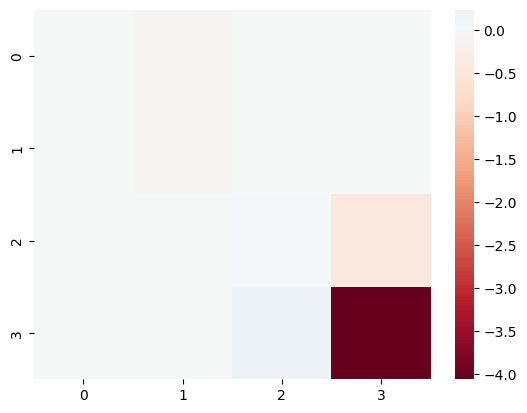

In [16]:
print((e_ij * c_ij).round(2))
sns.heatmap(e_ij * c_ij, center=0, cmap="RdBu")

# Transform DeepMoD humanTS

In [2]:
out_dir_org = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/deepmod_output/output_LRZ_Cluster_10-27_structured/humanTS_Genus10/ALR_female/"

data_dir = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/Python/ALR_transformation/ALR_transformed_data/"
n_taxa = 10

plot_output = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/Plots/"

# store standard matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
data =  pd.read_csv(f'{data_dir}ALR_denom-10-other_ts_female_Genus_10_most_abundant_rel_counts.csv')
t = data["Time"].to_numpy()
matrix = data.to_numpy()[:,1:]

## for int1 library

In [ ]:
out_dir = out_dir_org + "/int1/"
T = len(t)

runs = [s for s in os.listdir(out_dir) if "run" in s and "int1" in s and "." not in s]

for file in runs:
    # file = "output_batch_10-24_humanTS_female_run00_female_Genus10_ALR_2_50_th0-01_int1"

    names = pd.read_csv(f'{out_dir}{file}/Data/Names.csv', header=0)
    
    # print(pd.read_csv(f'{out_dir_org}{file}/Data/model_estimated_coeffs.csv', header=0, index_col=0))
    estimated_coeffs = pd.read_csv(f'{out_dir}{file}/Data/model_estimated_coeffs.csv', header=0, index_col=0).to_numpy()
    G = estimated_coeffs.transpose()

    n = G.shape[0]

    # Calculate dx/dt for each x_i
    dxdt = np.dot(G, matrix.transpose())

    # Calculate e_ij for each pair of x_i and x_j
    e_ij = G  # Since e_ij is just g_ij

    # Calculate c_ij for each pair of x_i and x_j
    c_ijt = np.zeros((n, n, T))
    for i in range(n):
        for j in range(n):
            c_ijt[i, j, :] = e_ij[i, j] * dxdt[j, :]

    # Calculate c_ij
    c_ij = np.sum(c_ijt**2, axis = 2) / np.sum(c_ijt**2)

    # save effects, weights and weighted_effects
    effects = pd.DataFrame(e_ij, columns=names["Names"])
    effects.to_csv(f"{out_dir}{file}/Data/effectsMat.csv", index=False)

    weights = pd.DataFrame(c_ij, columns=names["Names"])
    weights.to_csv(f"{out_dir}{file}/Data/weightsMat.csv", index=False)

    weighted_effects = pd.DataFrame(e_ij*c_ij, columns=names["Names"])
    weighted_effects.to_csv(f"{out_dir}{file}/Data/weighted_effectsMat.csv", index=False)


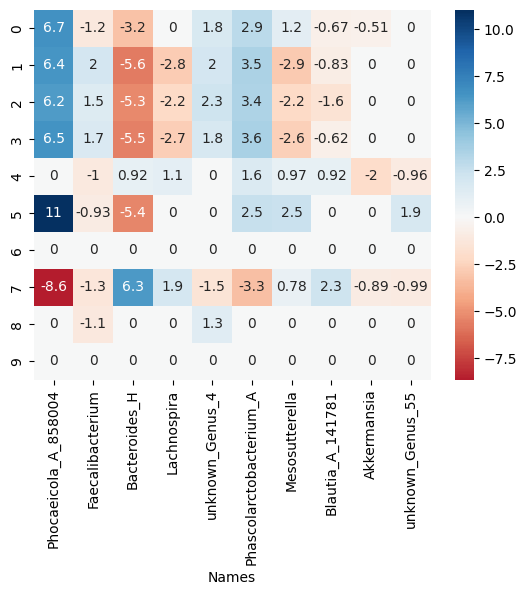

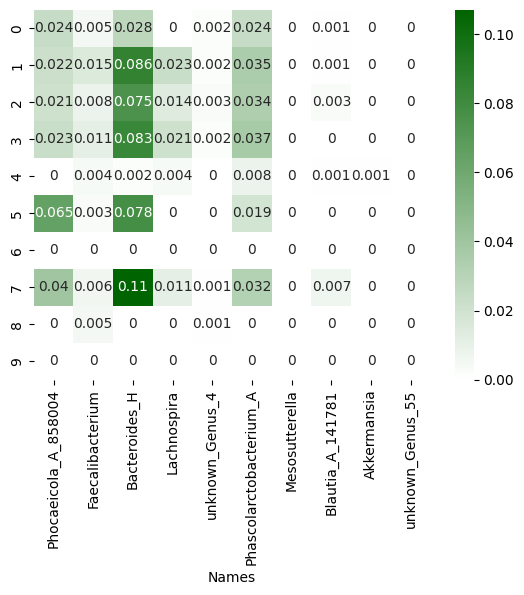

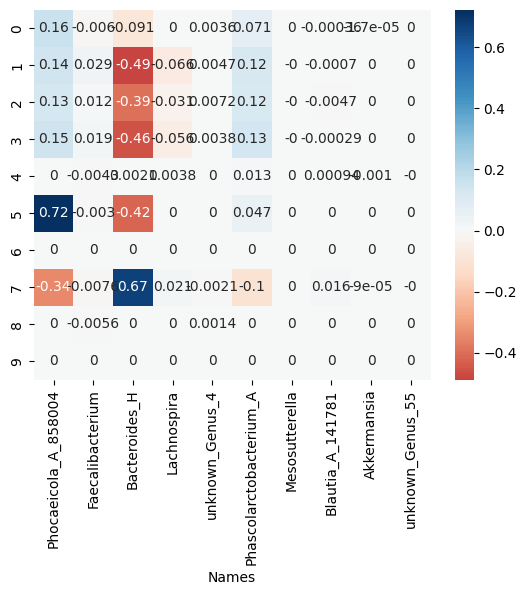

In [8]:
sns.heatmap(effects, center=0, cmap="RdBu", annot=True)
plt.show()

sns.heatmap(weights.round(3), vmin=0, cmap=cmap_green, annot=True)
plt.show()

sns.heatmap(weighted_effects, center=0, cmap="RdBu", annot=True)
plt.show()

## for int2 library

In [11]:
# Function to compute dx/dt for a given x, g, and A
def dx_dt(x, g, A):
    return g + np.dot(x, A)

# Function to compute eij values for a given x, g, and A
def compute_eij(x, g, A):
    n = len(g)
    e = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                e[i,j] = g[i] - x[i] - np.sum(A[i,:] * x)
            else:
                e[i,j] = A[i,j] * x[i] - A[j,i] * x[j]
                
    return e

In [13]:
out_dir = out_dir_org + "int2/"
T = len(t)

runs = [s for s in os.listdir(out_dir) if "run" in s and "int2" in s and "." not in s]

for file in runs:

    names = pd.read_csv(f'{out_dir}{file}/Data/Names.csv', header=0)
    
    estimated_coeffs = pd.read_csv(f'{out_dir}{file}/Data/model_estimated_coeffs.csv', header=0, index_col=0).to_numpy()
    g = estimated_coeffs[0,:]
    A = estimated_coeffs[1:(n_taxa+1),:].transpose()

    n = n_taxa

    # Initialize matrices to store summed values
    eij_values_sum = np.zeros((n, n))
    c_values = np.zeros((n, n, len(t)))

    # Loop over all time steps to compute eij and cij values for each t
    for index in range(len(t)):
        x_t = matrix[index, :]       # Extract x values for current time step
        eij_t = compute_eij(x_t, g, A)   # Compute eij for current time step
        
        dx_dt_t = dx_dt(x_t, g, A)   # Compute dx/dt for current time step
        for i in range(n):
            for j in range(n):
                # Compute cijt for current time step using eij and dx/dt values
                c_values[i, j, index] = dx_dt_t[j] * eij_t[i, j]
        eij_values_sum += eij_t      # Accumulate eij values for all t

    # Calculate mean eij over all time steps
    e_ij = eij_values_sum / len(t)

    # Initialize matrix to store the final cij values
    c_ij = np.zeros((n, n))

    # Loop over all i, j to compute cij values
    for i in range(n):
        for j in range(n):
            c_sum_squared = np.sum(c_values[i, j, :] ** 2)
            # Calculate cij using the formula given
            c_ij[i, j] = (np.sum(c_values[:, :, :] ** 2) ** -1) * c_sum_squared

    # save effects, weights and weighted_effects
    effects = pd.DataFrame(e_ij, columns=names["Names"])
    effects.to_csv(f"{out_dir}{file}/Data/effectsMat.csv", index=False)

    weights = pd.DataFrame(c_ij, columns=names["Names"])
    weights.to_csv(f"{out_dir}{file}/Data/weightsMat.csv", index=False)

    weighted_effects = pd.DataFrame(e_ij*c_ij, columns=names["Names"])
    weighted_effects.to_csv(f"{out_dir}{file}/Data/weighted_effectsMat.csv", index=False)


In [ ]:
sns.heatmap(effects, center=0, cmap="RdBu", annot=True)
plt.show()

sns.heatmap(weights.round(3), vmin=0, cmap=cmap_green, annot=True)
plt.show()

sns.heatmap(weighted_effects, center=0, cmap="RdBu", annot=True)
plt.show()

## for int3 library

In [4]:
# Function to compute dx/dt based on lib3
def dx_dt(x, g, A, B):
    n = len(x)
    dx = np.zeros(n)
    
    for i in range(n):
        dx[i] = g[i] * x[i]
        for j in range(n):
            dx[i] += A[i, j] * x[i] * x[j]
            for k in range(n):
                dx[i] += B[i][j * n + k] * x[i] * x[j] * x[k]
                
    return dx

def compute_derivatives(g, A, B, x):
    n, T = x.shape
    e = np.zeros((n, n, T))
    dx_dt = np.zeros((n, T))

    def get_b_index(N, j, k):
        """Helper function to get the index in B for (j, k) pair"""
        total = 0
        for i in range(j):
            total += N - i
        return total + k -j

    # Calculate dx/dt for each i and t
    for i in range(n):
        for t in range(T):
            dx_dt[i, t] = g[i] * x[i, t]
            for j in range(n):
                dx_dt[i, t] += A[i, j] * x[i, t] * x[j, t]
                for k in range(j, n):
                    idx = get_b_index(n, j, k)
                    dx_dt[i, t] += B[i, idx] * x[i, t] * x[j, t] * x[k, t]
    
    # Calculate e_ijt for each i, j, and t
    for i in range(n):
        for j in range(n):
            for t in range(T):
                if i == j:
                    e[i, j, t] = g[i]
                e[i, j, t] += A[i, j] * x[i, t]
                for k in range(j, n):
                    idx = get_b_index(n, j, k)
                    e[i, j, t] += B[i, idx] * x[i, t] * x[k, t]

    
    # Calculate e_ij as mean over all t
    e_ij = np.mean(e, axis=2)

    # Calculate c_ijt for each i, j, and t and relative sum over squared means afterwards
    c_ijk = dx_dt * e
    c_ij = np.sum(c_ijk**2, axis=2) / np.sum(c_ijk**2)

    return e_ij, c_ij

In [7]:
out_dir = out_dir_org + "int3/"
T = len(t)
x = matrix.transpose()
n = n_taxa

# Check if x has the correct shape
if x.shape == (n, T):
    print("Data matrix x has the correct shape.")
else:
    print(f"Data matrix x shape is {x.shape}, but expected shape is ({n}, {T}).")

runs = [s for s in os.listdir(out_dir) if "run" in s and "int3" in s and "." not in s]

for file in runs:

    names = pd.read_csv(f'{out_dir}{file}/Data/Names.csv', header=0)
    
    estimated_coeffs = pd.read_csv(f'{out_dir}{file}/Data/model_estimated_coeffs.csv', header=0, index_col=0).to_numpy()
    g = estimated_coeffs[0,:]
    A = estimated_coeffs[1:(n_taxa+1),:].transpose()
    B = estimated_coeffs[(n_taxa+1):,:].transpose()
    
    # Check if B has the correct shape
    if B.shape == (n, (n*(n+1)/2)):
        print("Matrix B has the correct shape.")
    else:
        print(f"Matrix B shape is {B.shape}, but expected shape is ({n}, {n*(n+1)/2}).")

    # calculate e_ij and c_ij
    e_ij, c_ij = compute_derivatives(g, A, B, x)

    # save effects, weights and weighted_effects
    effects = pd.DataFrame(e_ij, columns=names["Names"])
    effects.to_csv(f"{out_dir}{file}/Data/effectsMat.csv", index=False)

    weights = pd.DataFrame(c_ij, columns=names["Names"])
    weights.to_csv(f"{out_dir}{file}/Data/weightsMat.csv", index=False)

    weighted_effects = pd.DataFrame(e_ij*c_ij, columns=names["Names"])
    weighted_effects.to_csv(f"{out_dir}{file}/Data/weighted_effectsMat.csv", index=False)


Data matrix x has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.
Matrix B has the correct shape.


In [43]:
# # verify if get_b_index() works correctly

# n_outputs = n
# # initialize lists for string output
# comb_all_chr = []
# comb_2D_chr = []
# for i in np.arange(n_outputs):
#     for j in np.arange(i, n_outputs):
#         comb_2D_chr.append(f"x{i+1}*x{j+1}")
# for output in np.arange(n_outputs):
#     int_3D_chr = [f"x{output+1}*" + x for x in comb_2D_chr]
#     theta_i_chr = []
#     theta_i_chr.extend(int_3D_chr) # 3rd order terms (only including x_i)
#     comb_all_chr.append(theta_i_chr)
# B_coeffs = comb_all_chr
# print(B_coeffs)

# def get_b_index(N, j, k):
#     """Helper function to get the index in B for (j, k) pair"""
#     total = 0
#     for i in range(j):
#         total += N - i
#     return total + k -j

# for j in range(n):
#     for k in range(j, n):
#         idx = get_b_index(n, j, k)
#         print(j, k, "->", idx, "|", j+1, k+1, "->", B_coeffs[0][idx], "(", B[0,idx], ")")

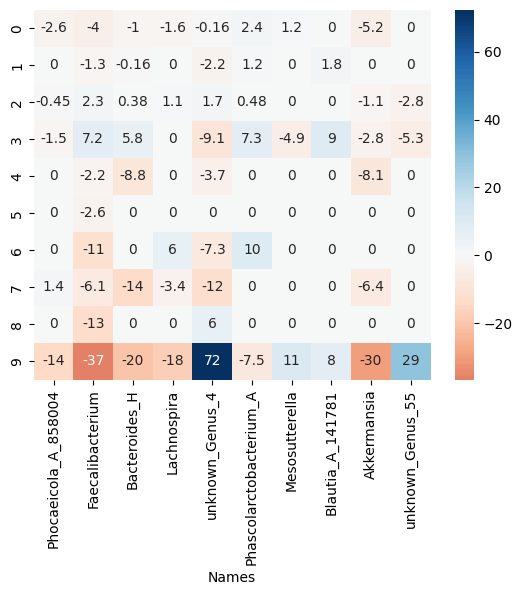

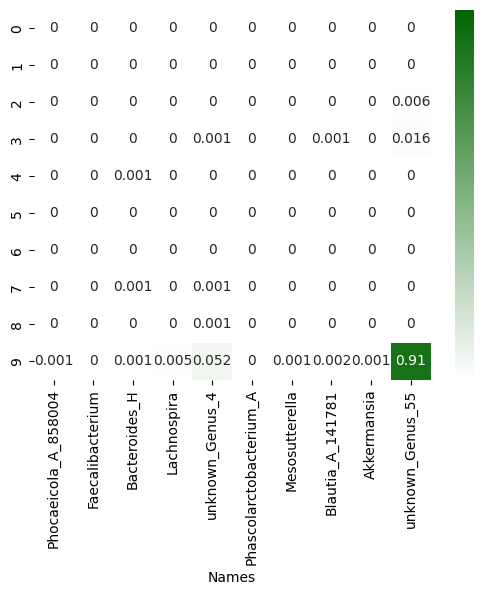

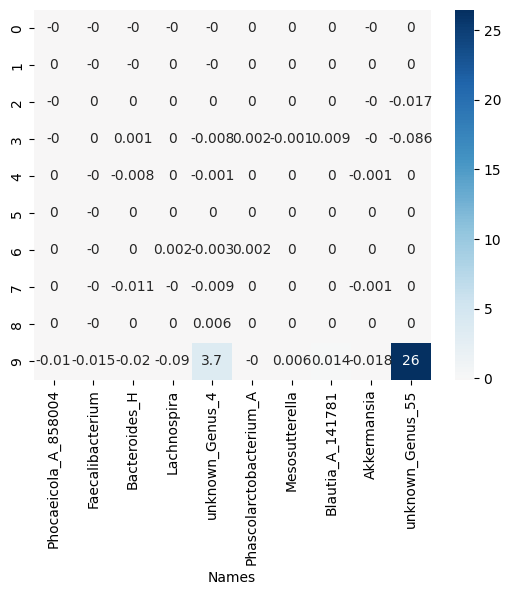

In [9]:
sns.heatmap(effects, center=0, cmap="RdBu", annot=True)
plt.show()

sns.heatmap(weights.round(3), vmin=0, cmap=cmap_green, annot=True,
            norm=SymLogNorm(linthresh=1, linscale=1, vmin=0, vmax=1))
plt.show()

ax = sns.heatmap(weighted_effects.round(3), center=0, cmap="RdBu", annot=True)
plt.show()